In [19]:
import SimpleITK as sitk
import numpy as np, torch, nrrd, pandas as pd
import monai.metrics as met

In [4]:
data = pd.read_csv('/Users/joemarsilla/Downloads/pred/pddca2/pddca_.csv', index_col=0)

In [5]:
data.head()

,0,1
0,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...
1,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...
2,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...
3,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...
4,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...,/cluster/projects/radiomics/EXTERNAL/PDDCA/052...


In [6]:
pats = list(data['0'])

In [7]:
p = [p.split('/')[-2] for p in pats]

In [8]:
# p = list(set(p))

In [9]:
from collections import OrderedDict
p = OrderedDict((x, True) for x in p).keys()

In [10]:
p = list(p)

In [11]:
p

['0522c0001',
 '0522c0002',
 '0522c0003',
 '0522c0009',
 '0522c0013',
 '0522c0014',
 '0522c0017',
 '0522c0057',
 '0522c0070',
 '0522c0077',
 '0522c0079',
 '0522c0081',
 '0522c0125',
 '0522c0132',
 '0522c0147',
 '0522c0149',
 '0522c0159',
 '0522c0161',
 '0522c0190',
 '0522c0195',
 '0522c0226',
 '0522c0248',
 '0522c0251',
 '0522c0253',
 '0522c0328',
 '0522c0329',
 '0522c0330',
 '0522c0427',
 '0522c0433',
 '0522c0441',
 '0522c0455',
 '0522c0457',
 '0522c0479',
 '0522c0555',
 '0522c0576',
 '0522c0598',
 '0522c0659',
 '0522c0661',
 '0522c0667',
 '0522c0669',
 '0522c0708',
 '0522c0727',
 '0522c0746',
 '0522c0788',
 '0522c0806',
 '0522c0845',
 '0522c0857',
 '0522c0878']

In [12]:
pddca_classes = ['BrainStem', 'Chiasm', 'Mandible', 'OpticNerve_L', 'OpticNerve_R', 'Parotid_L', 'Parotid_R']
# deep_classes2 = ['Brainstem','Lens_Lt', 'Lens_Rt', 'Mandible', 'Optic_Nerve_Lt', 'Optic_Nerve_Rt', 'Parotid_Lt', 'Parotid_Rt', 'Orbit_Lt', 'Orbit_Rt', 'Spinal_Cord', 'Spinal_Canal']
index_ = [1, 18, 5, 16, 17, 6, 7]
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

In [13]:
len(index_)

7

In [14]:
len(pddca_classes)

7

In [15]:
# import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    print(len(shape), shape, outs.size())
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    class_ = int(torch.max(targ).item())
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ[0] == i] = 1
        targets_out[0, i][outs[0] == i] = 1

    return targets_out, targets_dice


In [16]:
def resample_sitk(image, mode="linear", new_spacing=None, filter=False ): # new_spacing=np.array((1.0, 1.0, 2.0)) , filter=True
    if new_spacing is not None: # originally taken from https://github.com/SimpleITK/SimpleITK/issues/561
        resample = sitk.ResampleImageFilter()
        if mode == "linear":
            resample.SetInterpolator = sitk.sitkLinear  # use linear to resample image
        else: # use sitkNearestNeighbor interpolation # best for masks
            resample.SetInterpolator = sitk.sitkNearestNeighbor
        orig_size = np.array(image.GetSize(), dtype=np.int)
        orig_spacing = np.array(image.GetSpacing())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetOutputPixelType(image.GetPixelIDValue())
        new_spacing = new_spacing
        resample.SetOutputSpacing(new_spacing)
        new_size = orig_size * (orig_spacing / new_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resample.SetSize(new_size)
        if filter is True: # fights artifacts produced by analaising # only do this when resampling image (not mask...)
            img = resample.Execute(sitk.SmoothingRecursiveGaussian(image, 2.0))
        else:
            img = resample.Execute(image)
    else: # do nothing to the image...
        img = image
    return img

In [17]:
oars = []
pddca_oars = []
dce =  []
hd =   []
sd =   []
ob = []
p_ = []

In [28]:
# path of folders...
# observer = 'radiographer'
path = f'/Users/joemarsilla/Downloads/data/PDDCA/' 

for i, pat in enumerate(p):
    path_ = path+pat+'/structures/'
    # load subsequent patient outputs from model...
    # f'/Users/joemarsilla/Downloads/out/outs_{i}_FULL.npy' #
    out_path = f"/Users/joemarsilla/Downloads/pred/pddca2/FINAL_/outs_{i}_FULL.nrrd"
    # f'/Users/joemarsilla/Downloads/test/outs_{i}_FULL.npy' # 
    # outputs = torch.from_numpy(np.load(out_path))
    outputs = torch.from_numpy(nrrd.read(out_path)[0])
    # targets = torch.from_numpy(np.load(out_path.replace('outs', 'in')))
    outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    try:
        for k, val in enumerate(index_):
            try:
                targ = sitk.ReadImage(path_+pddca_classes[k]+'.nrrd')
        #       img = self.resample_sitk(img, new_spacing=np.array((1.0, 1.0, 2.0)))
        #       targ = resample_sitk(targ, mode="nearest", new_spacing=np.array((1.0, 1.0, 2.0)))
                targ = torch.tensor(sitk.GetArrayFromImage(targ))
                tsize = targ.size()
                print(tsize)
                outs = outputs[0,val]
                osize = outs.size()
                if osize[0] != tsize[0]:
                    diff = osize[0] - tsize[0]
                    a = diff//2
                    difff = diff - a
                    outs = outs[a:osize[0]-difff]
                    osize = outs.size()
                    assert osize[0] == tsize[0]
                print(osize)
                if osize[0]>tsize[0]:
                    diff = osize[0] - tsize[0]
                    a = diff//2
                    difff = diff - a
                    outs = outs[a:osize[0]-difff]
                
                outs = outs[osize[0]//8:osize[0]-osize[0]//8]
                targ = targ[osize[0]//8:osize[0]-osize[0]//8]
                dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))
                h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
                s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), include_background=False)
                print(chosen[val-1], dc, h)
                # save metrics...
                dce.append(dc[0][0].item())
                hd.append(h[0][0].item())
                sd.append(s[0][0].item())
        #       ob.append(observer)
                pddca_oars.append(pddca_classes[k])
                oars.append(chosen[val-1])
                p_.append(pat)
            except Exception as e:
                print(e)
                print(f'No {val} in {p[i]}')
    except Exception as e:
        print(e)
        print(p[i], ' is BAD.')
    
#     break

4 torch.Size([1, 112, 512, 512]) torch.Size([1, 112, 512, 512])
19
(1, 20, 112, 512, 512)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
BSTEM tensor([[0.6156]]) tensor([[5.3852]], dtype=torch.float64)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
CHIASM tensor([[0.2538]]) tensor([[5.7446]], dtype=torch.float64)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
MAND tensor([[0.7926]]) tensor([[3.1623]], dtype=torch.float64)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
LOPTIC tensor([[0.4738]]) tensor([[1.9732]], dtype=torch.float64)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
ROPTIC tensor([[0.4563]]) tensor([[2.2361]], dtype=torch.float64)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
LPAR tensor([[0.7937]]) tensor([[2.4495]], dtype=torch.float64)
torch.Size([107, 512, 512])
torch.Size([107, 512, 512])
RPAR tensor([[0.7648]]) tensor([[3.]], dtype=torch.float64)
4 torch.Size([1, 130, 512, 512]) torch.Size([1, 130, 512, 512])
19


/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:158: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/surface_distance.py:153: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/surface_distance.py:155: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warni

CHIASM tensor([[nan]]) tensor([[nan]], dtype=torch.float64)
torch.Size([145, 512, 512])
torch.Size([145, 512, 512])
MAND tensor([[0.8227]]) tensor([[1.5890]], dtype=torch.float64)
torch.Size([145, 512, 512])
torch.Size([145, 512, 512])
LOPTIC tensor([[nan]]) tensor([[nan]], dtype=torch.float64)
torch.Size([145, 512, 512])
torch.Size([145, 512, 512])
ROPTIC tensor([[nan]]) tensor([[nan]], dtype=torch.float64)
torch.Size([145, 512, 512])
torch.Size([145, 512, 512])
LPAR tensor([[0.7893]]) tensor([[4.1231]], dtype=torch.float64)
torch.Size([145, 512, 512])
torch.Size([145, 512, 512])
RPAR tensor([[0.8616]]) tensor([[4.5826]], dtype=torch.float64)
4 torch.Size([1, 128, 512, 512]) torch.Size([1, 128, 512, 512])
19
(1, 20, 128, 512, 512)
torch.Size([128, 512, 512])
torch.Size([128, 512, 512])
BSTEM tensor([[0.7824]]) tensor([[4.1231]], dtype=torch.float64)
torch.Size([128, 512, 512])
torch.Size([128, 512, 512])
CHIASM tensor([[0.2623]]) tensor([[7.8740]], dtype=torch.float64)
torch.Size([128

In [26]:
p_

['0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001',
 '0522c0001']

In [19]:
outputs = torch.from_numpy(np.load(out_path))

In [20]:
outputs.max()

tensor(0.)

In [61]:
len(oars)

307

In [31]:
data_ = {}
data_['OAR'] = oars
data_['OAR_PDDCA'] = pddca_oars
data_['Patient'] = p_
data_['VolDice'] = dce
data_['95HD'] = hd
data_['SurfDice'] = sd
# data_['Observer'] = ob

In [32]:
data_ = pd.DataFrame.from_dict(data_)
data_.to_csv('/Users/joemarsilla/OARensemble2021_pddca2.csv')
data_
# data_['OAR'] = data_['OAR'].fillna("CHIASM")
# data_.to_csv('/Users/joemarsilla/OARensemble2021_pddca2.csv')

,OAR,OAR_PDDCA,Patient,VolDice,95HD,SurfDice
0,BSTEM,BrainStem,0522c0001,0.615593,5.385165,2.962209
1,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
2,MAND,Mandible,0522c0001,0.773946,119.782929,10.392025
3,LOPTIC,OpticNerve_L,0522c0001,0.473795,1.973205,0.901536
4,ROPTIC,OpticNerve_R,0522c0001,0.456274,2.236068,1.027852
...,...,...,...,...,...,...
351,MAND,Mandible,0522c0878,0.858215,1.414214,0.641228
352,LOPTIC,OpticNerve_L,0522c0878,0.503497,3.707631,0.868498
353,ROPTIC,OpticNerve_R,0522c0878,0.367201,2.236068,1.182157
354,LPAR,Parotid_L,0522c0878,0.853995,2.828427,0.802964


In [33]:
data_[data_['OAR'] == "CHIASM"]
# images of different sizes (sliding window must be different)
# exclude = ['0522c0727b', '0522c0727a']

,OAR,OAR_PDDCA,Patient,VolDice,95HD,SurfDice
1,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
8,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
15,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
22,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
29,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
36,CHIASM,Chiasm,0522c0002,0.372340,5.084167,1.747751
43,CHIASM,Chiasm,0522c0003,0.344676,4.358899,1.650466
50,CHIASM,Chiasm,0522c0009,0.380556,4.123106,1.553559
57,CHIASM,Chiasm,0522c0013,0.335766,6.324555,1.681447
64,CHIASM,Chiasm,0522c0014,0.341530,4.242641,1.458458


In [34]:
data_

,OAR,OAR_PDDCA,Patient,VolDice,95HD,SurfDice
0,BSTEM,BrainStem,0522c0001,0.615593,5.385165,2.962209
1,CHIASM,Chiasm,0522c0001,0.253788,5.744563,1.998870
2,MAND,Mandible,0522c0001,0.773946,119.782929,10.392025
3,LOPTIC,OpticNerve_L,0522c0001,0.473795,1.973205,0.901536
4,ROPTIC,OpticNerve_R,0522c0001,0.456274,2.236068,1.027852
...,...,...,...,...,...,...
351,MAND,Mandible,0522c0878,0.858215,1.414214,0.641228
352,LOPTIC,OpticNerve_L,0522c0878,0.503497,3.707631,0.868498
353,ROPTIC,OpticNerve_R,0522c0878,0.367201,2.236068,1.182157
354,LPAR,Parotid_L,0522c0878,0.853995,2.828427,0.802964


In [66]:
# fdata = data_[~data_.Patient.isin(exclude)]
# exclude = ['Spinal-Canal']
# fdata = fdata[~fdata.OAR_Deepmind.isin(exclude)]

In [1]:
# fdata
import pandas as pd
data_=pd.read_csv('/Users/joemarsilla/OARensemble2021_pddca2.csv')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_4629/2035928046.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 100)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_4629/2035928046.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0, 0.5, '3D Volumetric Dice\n')

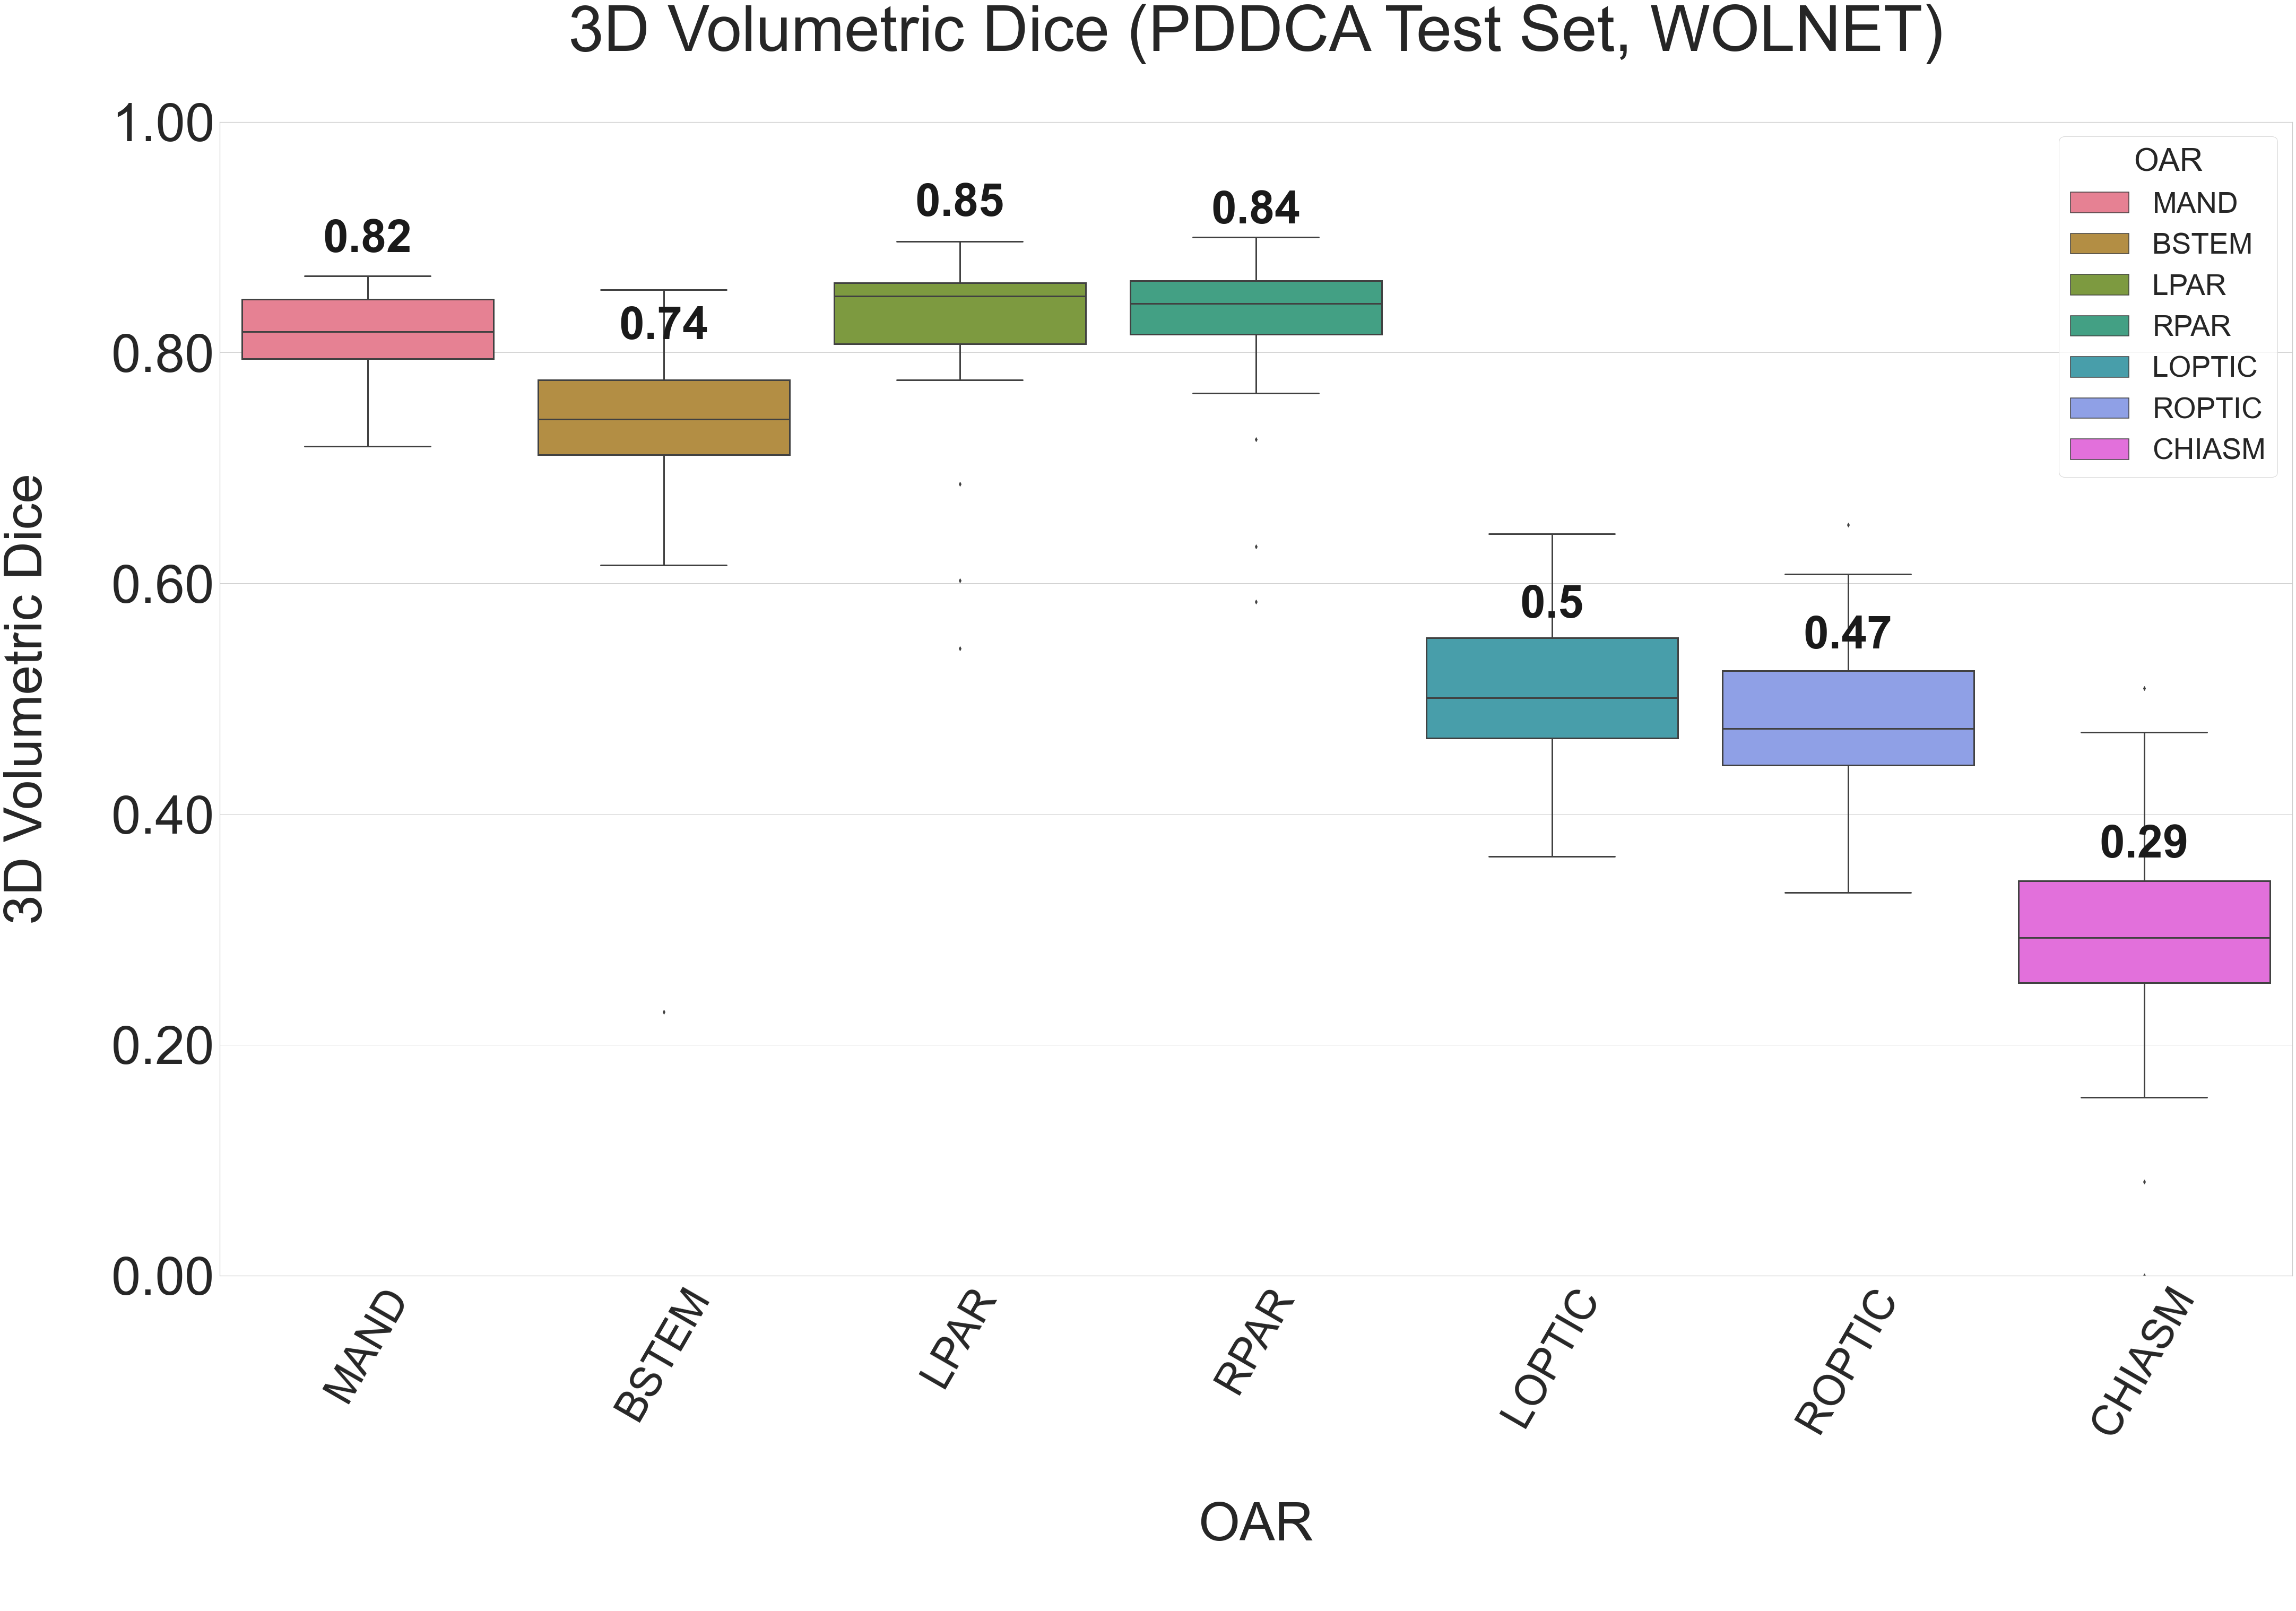

In [38]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
# sea.color_palette("Set1")
sea.set_palette("husl", 7)
plt.title('3D Volumetric Dice (PDDCA Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'BSTEM', 'LPAR', 'RPAR', 'LOPTIC', 'ROPTIC', 'CHIASM']
# rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
data_.OAR = data_.OAR.astype("category")
data_.OAR.cat.set_categories(rois, inplace=True)
data_.sort_values(["OAR"])
medians = data_.groupby(['OAR'])['VolDice'].median()
vertical_offset = data_['VolDice'].median() * 0.095 # offset from median for display
ax = sea.boxplot(data=data_, x="OAR", y="VolDice", hue="OAR", hue_order=rois, width=.85, linewidth=3,  dodge=False) # hue_order=chosen,
ax.set_ylim(0,1)
ax.set_yticklabels(ax.get_yticks(), size = 100)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
# plt.ylim(0.,1.)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
# ax.legend_.remove()

/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_4629/327239306.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 100)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_4629/327239306.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0, 0.5, '95%HD\n')

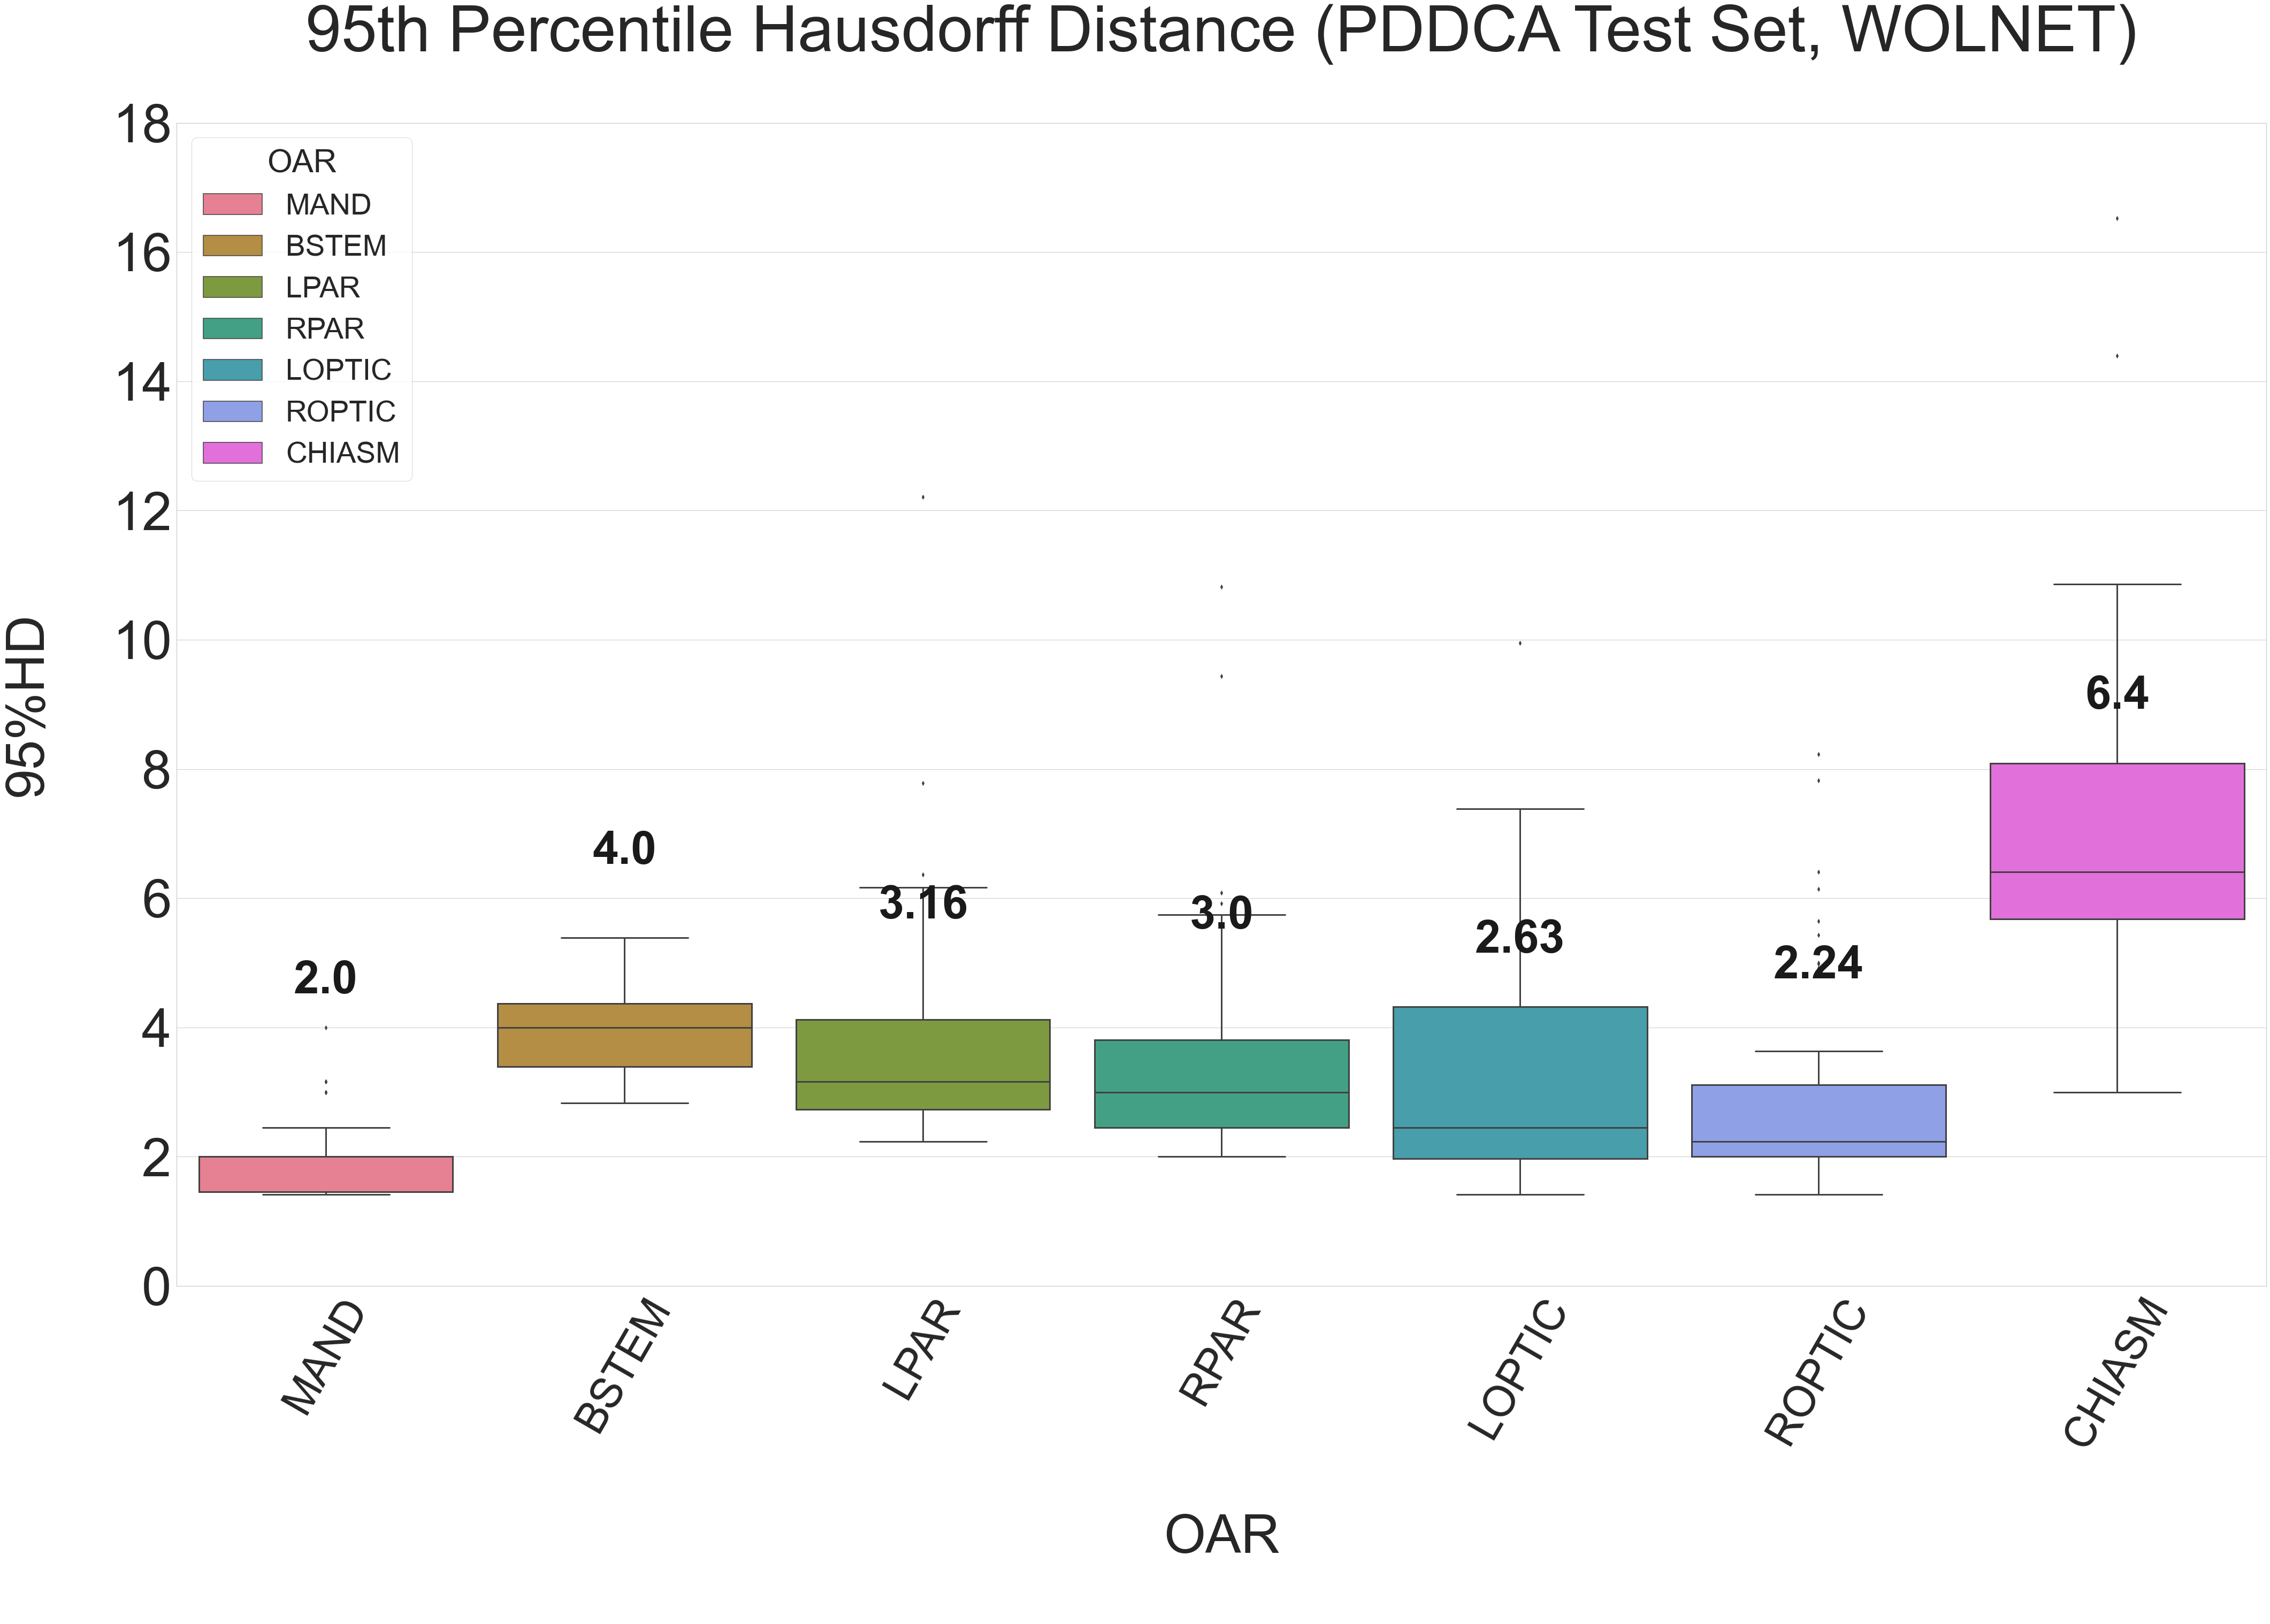

In [36]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
# sea.color_palette("Set2")
sea.set_palette("husl", 7)
plt.title('95th Percentile Hausdorff Distance (PDDCA Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=data_[data_["95HD"]<17.5], x="OAR", y="95HD", hue="OAR",hue_order=rois, width=.85, linewidth=3, dodge=False)
ax.set_ylim(0,18)
ax.set_yticklabels(ax.get_yticks(), size = 100)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
medians = data_.groupby(['OAR'])['95HD'].median()
vertical_offset = data_['95HD'].median() * .8 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
# ax.legend_.remove()